In [1]:
import theano
import theano.tensor as T
import numpy as np
from neuralnet import build_neural_net

Using gpu device 0: GeForce GT 755M (CNMeM is disabled, cuDNN 5005)


When imported, the MNIST images are one dimensional uint8 arrays. For the sake of the neural network, the entries in the image are converted to the 

In [2]:
def deprocess(array, new_shape=None):
    if new_shape != None:
        array = array.reshape(new_shape)
    return np.clip(array * 255., 0, 255).astype('uint8')

Here I am setting up the relevant symbolic variables. Note that the neural network is being built using weights that have already been trained on the MNIST dataset. We will use this neural network to generate adversarial images. The adversarial image is an MNIST image, with a bit of noise added.

In [15]:
image = T.vector()
target = T.vector()
noise = theano.shared(np.asarray(np.random.randn(784), dtype=theano.config.floatX))
adv_image = image + noise
output, _, _ = build_neural_net(adv_image, 'mnist_weights.npy')

I have defined the loss function to be the mean squared error, plus the sum of the squared entries in our noise vector. The second summand of the loss function ensures that the optimized noise will alter the image as little as possible. The whole point is that we want to trick the neural network using an amount of noise that would be imperceptable or, at least, not obvious to the human eye. This way to us the adversarial image will look more or less the same as the original, but to the computer it will "look" completely different.

In [16]:
loss = T.mean(T.sqr(output - target)) + T.mean(T.sqr(noise))
updates = [(noise, noise - T.grad(cost=loss, wrt=noise))]

Here I am defining a few functions that will be compiled by Theano at runtime. Note that when `optimize_noise` is called, `noise` will be re-assigned as `noise - T.grad(cost=loss, wrt=noise)`. As such, we're really just performing gradient descent.

Each of the functions should be self-evident, except for `evaluate` which will return two items: the predicted digit and the level of confidence.

In [17]:
optimize_noise = theano.function(inputs=[image, target], outputs=loss, updates=updates, allow_input_downcast=True)
get_adv_image = theano.function(inputs=[image], outputs=adv_image, allow_input_downcast=True)

i = T.argmax(output)
evaluate = theano.function(inputs=[image], outputs=[i, output[0,i]], allow_input_downcast=True)

Now let's get the MNIST dataset

In [18]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./data')
zero_img = mnist.data[0] / 255.

Now let's take a look at the first digit in the MNIST dataset, which happens to be a zero, and run it through our neural network.

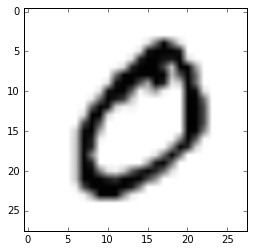

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(deprocess(zero_img, (28, 28)), cmap='Greys')
plt.show()

In [20]:
prediction, confidence = evaluate(zero_img)
print 'predicted the number', prediction, 'with a confidence of', confidence * 100, '%'

predicted the number 2 with a confidence of 82.348793745 %


Now we will use the previously defined machinery to generate an adversarial image. Notice that we're using a one-hot-encoding to represent a target output value of five.

In [21]:
for i in range(5000):
    error = optimize_noise(zero_img, [0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

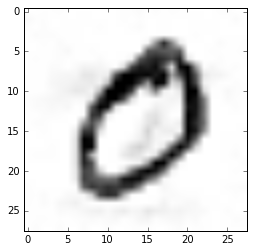

In [22]:
adv_zero_img = get_adv_image(zero_img)
plt.imshow(deprocess(adv_zero_img, (28, 28)), cmap='Greys')
plt.show()

In [23]:
prediction, confidence = evaluate(zero_img)
print 'predicted the number', prediction, 'with a confidence of', confidence * 100, '%'

predicted the number 7 with a confidence of 95.9307074547 %
